## Fouille de Textes
# Projet : Active Learning
#### Mamadou Mahdiou Diallo, Helmy El Rais, Dah Diarra
##### M2 Machine Learning for Data Science - Université Paris Descartes


## Sommaire
1. Introduction
2. Méthodes
3. Implémentation
4. Données synthétiques
5. Données NG5
6. Conclusion

## Introduction

L'Active Learning est une méthode d'apprentissage dans laquelle on permet à l'apprenant de choisir les exemples dont il apprendra en vue d'accélérer l'apprentissage. Cette méthode a de nombreux avantages:
- elle accélère l'apprentissage en utilisant uniquement les données les plus importantes
- elle diminue la quantité de données labélisées dont on a besoin.
- dans les situations où l'obtention de données d'apprentissage est coûteux (expériences scientifiques, longues simulations, etc.) elle permet de réduire les coûts et la durée des projets.

## Méthodes
Dans un algorithme d'Active Learning, il existe deux rôles [(Burr Settles, 2010)](http://burrsettles.com/pub/settles.activelearning.pdf) :
- L'apprenant: le modèle prédictif qu'on veut entraîner. C'est à lui de choisir les nouvelles données à labéliser.
- L'oracle: C'est l'entité qui connaît les classes des données d'apprentissage et peut les transmettre à l'apprenant à la demande. Il peut être un humain ou être simulé par un programme.

Il y a plusieurs types de problèmes (qu'on appelle scénarios) dans lesquels on peut utiliser l'Active Learning:
- L'apprenant peut générer de nouveaux exemples et demander à l'oracle de les labelliser (Membership Query Synthesis)
- Etant donné un flux d'examples, l'apprenant peut décider, pour chaque nouvel example s'il veut l'utiliser ou pas (Stream-based sampling)
- L'apprenant peut tester tous les examples et choisir ceux à partir desquels il veut apprendre (Pool-based sampling). C'est ce scénario que nous implémentons dans ce projet.

Après avoir défini le scénario, il faut aussi définir le critère de choix de nouveaux examples. La stratégie de choix est appelée "Query Strategy". Quelques stratégies existantes sont les suivantes: uncertainty sampling, query by committee, expected impact et density-weighted. 

En bref, query-by-committee entraîne plusieurs apprenants différents et les exemples sur lesquels les apprenants sont le plus en désaccord sont choisis pour l'apprentissage. La stratégie density-weighted utilise une mesure de la densité de l'information et choisi les exemples qui maximisent l'augmentation de celle-ci. La stratégie expected impact choisit les nouveaux exemples en fonction de l'apport qu'on espère obtenir du nouvel exemple; cela peut être la réduction du taux d'erreur, la réduction de la variance ou un changement significatif du modèle.

La stratégie la plus simple est Uncertainty Sampling. Dans cette stratégie, l'apprenant affecte des probabilités aux examples qui lui sont donnés et choisit ceux pour lesquels il est le plus "incertain". La mesure d'incertitude peut se faire de 3 manières différentes:
- Least Confidence sampling: (la plus petite confiance). Pour chacun des exemples, l'apprenant détermine la probabilité de la classe qui serait prédite. Les exemples qui ont la probabilité la plus basse sont choisis.
$$x^*_{LC} = \underset{x}{argmax}{1 - P_{\theta}(\hat{y}|x)} $$
où x est une donnée non labélisée, y est la classe prédite, $\theta$ représente l'hypothèse apprise par l'apprenant.

- Margin sampling: (la plus petite marge). Pour chacun des exemples, l'apprenant détermine la différence entre la classe la plus probable $\hat{y}_1$ et la seconde classe la plus probable $\hat{y}_2$. Les examples avec la plus petite différence sont choisis.
$$x^*_M = \underset{x}{argmax}{P_{\theta}(\hat{y}_1|x) - P_{\theta}(\hat{y}_2|x)} $$

- Entropy sampling: (l'entropie la plus élevée). Pour chacun des exemples, l'apprenant détermine l'entropie de la distribution des probabilités des classes. Les exemples pour lesquels l'entropie est la plus élevée sont choisis pour l'itération suivante.
$$x^*_H = \underset{x}{argmax}{-\underset{i}{\sum}{P_{\theta}(\hat{y}_i|x) log P_{\theta}(\hat{y}_i|x)}} $$

La stratégie implémentée dans ce projet est Uncertainty Sampling.

Le pseudocode de l'algorithme est comme suit:


**Input** : ensemble de données étiquetées **L**, et ensemble de données non étiquetées **U**

**Output** : ensemble de données étiquetées **L UNION U**

Tant que **U** non vide
1. Entraîner un classifieur **C** (par exemple, un simple classifieur bayesien naif) en utilisant **L**
2. Utiliser **C** pour prédire les données **U**
3. Sélectionner dans **U** *n* instances et former un ensemble **I** contenant ces instances
4. Demander à l’expert d’étiqueter **I**
5. Faire **L** = **L UNION I** et **U = U MOINS I**

## Implémentation

Notre implémentation inclut deux classes **Oracle** et **Learner** (apprenti) qui ont les rôles définis plus haut. Nous les avons développées en suivant le modèle défini par [Scikit-Learn](https://scikit-learn.org/stable/) : Une classe avec les méthodes `fit`, `predict`, `predict_proba` en plus d'autres méthodes comme on peut le voir sur l'image suivante:

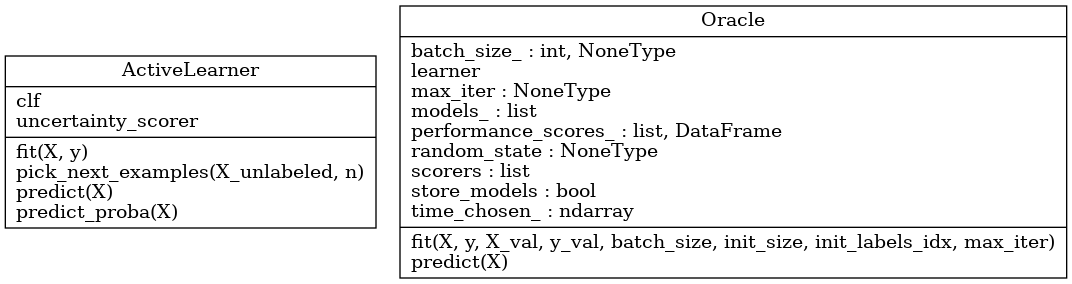

### Oracle:
C'est la classe qui représente celui qui connait les classes des exemples et les transmets à l'apprenant quand il les demande. Ses variables d'instance sont les suivantes:
- `learner`: L'apprenti
- `scorers`: une liste de fonctions de métriques de Scikit-Learn qui permettrons de suivre l'évaluation des modèles au cours de l'apprentissage
- `random_state`: pour assurer la répétabilité des résultats obtenus. Sa valeur est utilisée au cours de la sélection aléatoire des exemples initiaux.
- `max_iter`: le nombre d'itérations au terme duquel le modèle doit arrêter de s'entraîner.
- `store_models`: une variable booléenne qui donne l'option de sauvegarder une copie de l'apprenant après chaque itération.

Après avoir appelé fit sur un oracle, on a en plus les variables suivantes:
- `models_`: la liste des apprenants obtenus après chaque itération.
- `performance_scores_`: la liste des scores obtenus après chaque itération:
- `time_chosen_`: l'itération à laquelle chaque exemple a été sélectionné pour l'apprentissage.
- `batch_size_`: le nombre de nouveaux exemples à choisir au terme de chaque itération.

La fonction fit prend les paramètres suivant en plus de X et y habituels:
- `X_val`, `y_val`: l'ensemble des valeurs à utiliser pour mesurer l'évolution de la performance de l'apprenant. Par défaut il s'agit de l'ensemble d'apprentissage
- `batch_size`: le nombre de nouveaux exemples à choisir au terme de chaque itération.
- `init_size`, `init_label_idx`: le nombre d'exemples initiaux, ou les positions de ceux-ci dans l'ensemble d'apprentissage. Si ces valeurs sont toutes les deux nulles, on choisit un exemple à chaque itération.
- `max_iter`: le nombre d'itérations au terme duquel le modèle doit arrêter de s'entraîner.


### Learner:
C'est la classe qui représente l'apprenant. Ses variables d'instance sont les suivantes:
- `clf`: le modèle interne que l'apprenant utilisera.
- `uncertainty_scorer`: la variable qui pointera vers la fonction de mesure d'incertitude choisie

En plus des fonction habituelles de Scikit-Learn, cette classe a les fonctions suivantes:
- `pick_next_exampes`: la fonction qui permet de choisir les nouveaux exemples d'apprentissage. Elle se sert de `uncertainty_scorer`.
- les fonctions de mesure d'incertitude : `_uncertainty_scorer`, `_margin_scorer`, `_entropy_scorer` et `_random_scorer`. On utilise `_random_scorer` pour comparer le choix aléatoire à l'Uncertainty Sampling.

In [1]:
%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

#### Import des librairies

In [2]:
from active_learning import ActiveLearner, Oracle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# animation
from matplotlib import animation
from celluloid import Camera

# preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# data
from sklearn.datasets import fetch_20newsgroups, make_blobs

from sklearn.base import clone

#### Définition des fonction d'aide à la visualisation 

In [3]:
def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()

animation.Animation._repr_html_ = anim_to_html

`draw_choice` affiche les données d'apprentissage en fonction de leur état de sélection: initial, actuel, futur.

`add_model_boundaries` dessine la frontière de décision apprise par l'apprenant

In [4]:
def add_model_boundaries(ax, model, npts=100):
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    hx = (x_max - x_min)/npts
    hy = (y_max - y_min)/npts

    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx),
                         np.arange(y_min, y_max, hy))
    
    x = xx.ravel()
    y = yy.ravel()

    grid = np.c_[x, y]
    Z = model.predict(grid)
    
    probs = model.predict_proba(grid)
    probs = model.uncertainty_scorer(probs)
    
    colors = plt.cm.tab10(Z)
    colors[:, -1] = probs
    
    ax.scatter(x,y,c=colors,marker='.', s=6)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    return ax


def draw_choice(X, y, choice_order, ax, i, model, first=0):
    if i < 0:
        chosen = choice_order == -1
    else:
        chosen = choice_order == i
    
    choice = np.repeat('no', chosen.shape[0])
    choice = choice.astype('<U10')
    choice[(choice_order >= 0) & (choice_order <= i)] = 'yes'
    choice[choice_order == -1] = 'initial'
    
    pt_size = np.repeat('old', chosen.shape[0])
    pt_size[chosen] = 'new'
    pt_size = pd.Series(pt_size, name='selection time')
    
    choice = pd.Series(choice, name='chosen')
    target = pd.Series(y, name='class')
       
    sns.scatterplot(X[:,0], X[:,1],
                    ax=ax,
                    hue=target, palette='tab10',
                    size=pt_size,
                    size_order = ['new', 'old'],
                    sizes=(40, 80),
                    style=choice,
                    markers={'yes': 'o', 'no': 'X', 'initial': 's'},
                    legend='full' if i==first else None)
    
    if model is not None:
        add_model_boundaries(ax, model)
    
    if i == first:
        ax.legend(loc='center left', 
                  bbox_to_anchor=(1.01,.5))
    return ax

`animate_choices` génère une animation des points choisis au fil des itérations

In [5]:
def animate_choices(X, y, choice_order, models, interval=200, first=0):
    fig = plt.figure(figsize=(10,5))
    
    # to avoid the legend being clipped
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.9]) # [left, bottom, width, height]
    
    camera = Camera(fig)
    chosen = np.zeros(choice_order.shape, dtype=bool)
    for it in range(-5, choice_order.max()+5):
        idx = min(it, len(models)-1)
        model = None if idx < 0 else models[idx]
        draw_choice(X, y, choice_order, ax, it, model, first=first)
        camera.snap()

    return camera.animate(interval=interval)

`plot_choice_order` affiche le pourcentage d'éléments de chaque classe choisi au fil des itérations

In [6]:
def plot_choice_order(time_chosen, y, ax=None):
    choice_order = np.argsort(time_chosen)
    y = y[choice_order]
    labels = np.unique(y)
    classes = np.arange(labels.shape[0])
    class_mat = np.zeros((y.shape[0], classes.shape[0]), dtype=bool)
    for c in classes:
        class_mat[:, c] = y == labels[c]

    class_counts = class_mat.sum(axis=0)
    df_classes = pd.DataFrame(class_mat, columns=labels)

    percent_chosen = df_classes.cumsum(axis=0)/class_counts
    ax = percent_chosen.plot(cmap='tab10', ax=ax)
#     ax.legend(loc='center left',
#               bbox_to_anchor=(1.01,.5))
    return ax

## Données synthétiques
Nous commençons par tester l'implémentation sur des données synthétiques, faciles à visualiser et interpréter. On a deux classes proches et une troisième clairement séparée des autres.

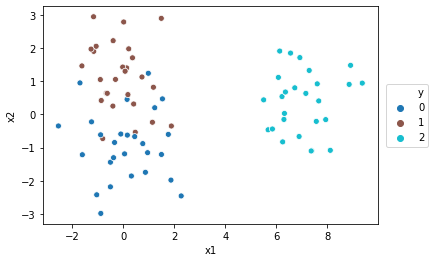

In [25]:
X, y = make_blobs(n_samples=80, centers=[(0,-1), (0,1), (7,0)], random_state=0)
data = pd.DataFrame({
    'x1': X[:, 0],
    'x2': X[:, 1],
    'y': y,
})

ax = sns.scatterplot(data.x1, data.x2,
                hue=data.y, palette='tab10',
                legend='full')
ax.legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=0)

#### Création et entraînement des classifieurs
Nous utilisons la régression logistique comme algorithme d'apprentissage

In [27]:
classifier = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', multi_class='auto'))
batch_size = 2
init_size = 3

In [28]:
clf = clone(classifier, safe=False)
lc_learner = ActiveLearner(clf, strategy='least_conf')
lc_oracle = Oracle(lc_learner, metrics=[precision_score, recall_score, f1_score], store_models=True, random_state=0)
lc_oracle.fit(X_train, y_train,
              batch_size=batch_size,
              init_size=init_size)

In [29]:
init_idx = lc_oracle.time_chosen_ == -1 # keep the same initialization for all methods

In [30]:
clf = clone(classifier, safe=False)
margin_learner = ActiveLearner(clf, strategy='margin')
margin_oracle = Oracle(margin_learner, metrics=[precision_score, recall_score, f1_score], store_models=True)
margin_oracle.fit(X_train, y_train,
                  batch_size=batch_size,
                  init_labels_idx=init_idx)

In [31]:
clf = clone(classifier, safe=False)
entropy_learner = ActiveLearner(clf, strategy='entropy')
entropy_oracle = Oracle(entropy_learner, metrics=[precision_score, recall_score, f1_score], store_models=True)
entropy_oracle.fit(X_train, y_train,
                  batch_size=batch_size,
                  init_labels_idx=init_idx)

In [32]:
clf = clone(classifier, safe=False)
rand_learner = ActiveLearner(clf, strategy='random')
rand_oracle = Oracle(rand_learner, metrics=[precision_score, recall_score, f1_score], store_models=True)
rand_oracle.fit(X_train, y_train,
                  batch_size=batch_size,
                  init_labels_idx=init_idx)

#### Visualisation des résultats

La figure suivante montre l'évolution du score de l'apprenant au fil des itérations. Dans ce cas-ci, les 4 méthodes semblent avoir des résultats similaires.

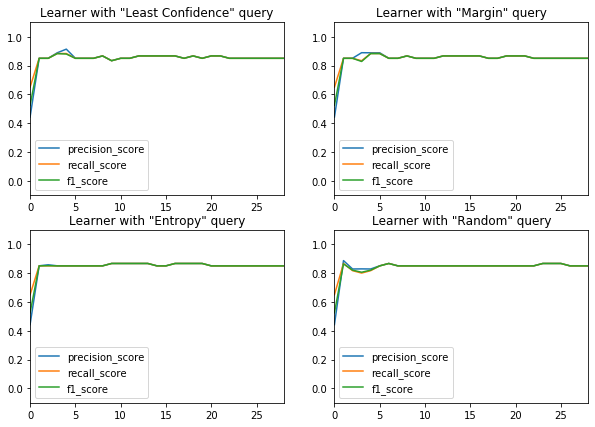

In [33]:
fig = plt.figure(figsize=(10,7))
fig.suptitle('Metrics evolution')
ax = plt.subplot(221)
lc_oracle.performance_scores_.plot(ax=ax)
ax.set_ylim(-.1, 1.1)
ax.set_title('Learner with "Least Confidence" query')

ax = plt.subplot(222)
margin_oracle.performance_scores_.plot(ax=ax)
ax.set_ylim(-.1, 1.1)
ax.set_title('Learner with "Margin" query')

ax = plt.subplot(223)
entropy_oracle.performance_scores_.plot(ax=ax)
ax.set_ylim(-.1, 1.1)
ax.set_title('Learner with "Entropy" query')


ax = plt.subplot(224)
rand_oracle.performance_scores_.plot(ax=ax)
ax.set_ylim(-.1, 1.1)
ax.set_title('Learner with "Random" query');

On peut aussi observer la forme de la frontière de décision. L'arrière plan de la figure suivante prend la couleur de la classe majoritaire pour chaque point de l'espace. La transparence de la couleur est proportionnelle à l'incertitude du modèle.

On peut noter que:
- Le modèle qui utilise "least confidence query" a une confiance haute. Cela est dû au fait que les 3 classes sont assez proches pour que la probabilité de chacune soit élevée à la frontière de décision.
- Le modèle qui utilise "margin query" a une confiance très basse au niveau de la frontière. Elle est même nulle aux points frontaliers. Cela est dû au fait que les deux classes de plus haute confiance ont à peu près la même probabilité.
- Le modèle qui utilise "entropy query" a une confiance plus basse au point où les trois classes sont frontalières. Cela découle de la définition de l'entropie. A ce point, les 3 classes sont équiprobables et donc l'entropie est maximale.
- Le modèle aléatoire n'a pas de frontière de décision.
- Dans chaque cas, les points choisis (en plus large) sont les plus proches de la frontière de décision qui n'ont pas déjà été choisis.

Text(0.5, 0.98, 'Chosen points at iteration 2')

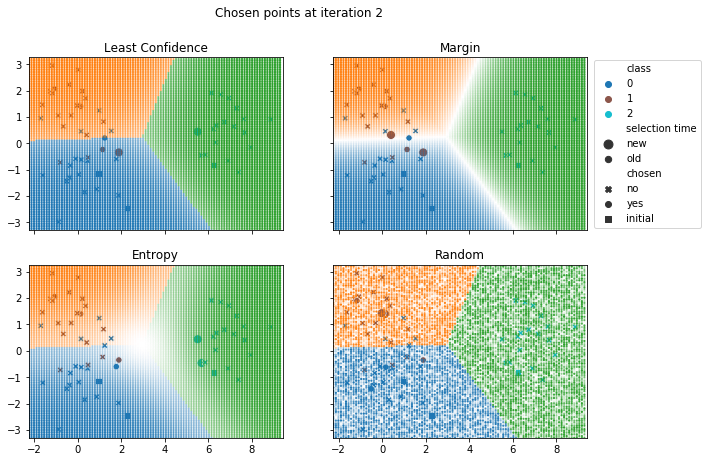

In [47]:
ncol = 2
fig, axs = plt.subplots(2,ncol, figsize=(10, 7), sharex=True, sharey=True)
it = 2
names = ['Least Confidence', 'Margin', 'Entropy', 'Random']
models = [(lc_learner, lc_oracle), 
          (margin_learner, margin_oracle), 
          (entropy_learner, entropy_oracle), 
          (rand_learner, rand_oracle)]

for i, (ax, name, (learner, oracle)) in enumerate(zip(axs.ravel(), names, models)):
    draw_choice(X_train, y_train, oracle.time_chosen_.copy(), ax, it, learner, first=it if (i+1)/ncol==1 else 0)
    ax.set_title(name)

fig.suptitle(f'Chosen points at iteration {it}')

##### Animation des choix des modèles au fil des itérations

In [35]:
choice_order = lc_oracle.time_chosen_.copy()
models = lc_oracle.models_
# choice_order[choice_order >= 0] = choice_order[choice_order >= 0] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [36]:
choice_order = margin_oracle.time_chosen_.copy()
models = margin_oracle.models_
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [37]:
choice_order = entropy_oracle.time_chosen_.copy()
models = entropy_oracle.models_
# choice_order[choice_order >= 0] = choice_order[choice_order >= 0] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [38]:
choice_order = rand_oracle.time_chosen_.copy()
models = rand_oracle.models_
# choice_order[choice_order != -1] = choice_order[choice_order != -1] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

Sur la figure suivante, on note clairement que les modèles choisissent les examples venant des classes qu'ils ont le plus de difficultés à séparer. Le modèle aléatoire choisit uniformément les exemples dans toutes les classes.

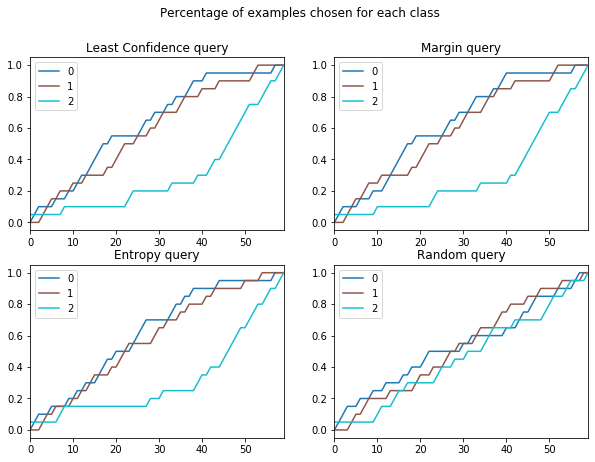

In [39]:
fig = plt.figure(figsize=(10,7))
fig.suptitle('Percentage of examples chosen for each class');

ax = plt.subplot(221)
ax = plot_choice_order(lc_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Least Confidence query')

ax = plt.subplot(222)
ax = plot_choice_order(margin_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Margin query')

ax = plt.subplot(223)
ax = plot_choice_order(entropy_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Entropy query')


ax = plt.subplot(224)
ax = plot_choice_order(rand_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Random query');

## Données NG5

In [53]:
categories = ['rec.motorcycles', 'rec.sport.baseball',
                'comp.graphics', 'sci.space',
                'talk.politics.mideast']
remove = ("headers", "footers", "quotes")
ng5_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
ng5_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

X_train, y_train = ng5_train.data, np.array(ng5_train.target)
X_test, y_test = ng5_test.data, np.array(ng5_test.target)

In [54]:
tfidf = TfidfVectorizer().fit(X_train)
X_train = tfidf.transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [56]:
classifier = make_pipeline(StandardScaler(), GaussianNB())
batch_size = 100
init_size = 100

In [57]:
clf = clone(classifier, safe=False)
lc_learner = ActiveLearner(clf, strategy='least_conf')
lc_oracle = Oracle(lc_learner, metrics=[precision_score, recall_score, f1_score], store_models=False, random_state=0)
lc_oracle.fit(X_train, y_train,
              batch_size=batch_size,
              init_size=init_size)

In [58]:
init_idx = lc_oracle.time_chosen_ == -1 # keep the same initialization for all methods

In [59]:
clf = clone(classifier, safe=False)
margin_learner = ActiveLearner(clf, strategy='margin')
margin_oracle = Oracle(margin_learner, metrics=[precision_score, recall_score, f1_score], store_models=False)
margin_oracle.fit(X_train, y_train,
                  batch_size=batch_size,
                  init_labels_idx=init_idx)

In [60]:
clf = clone(classifier, safe=False)
entropy_learner = ActiveLearner(clf, strategy='entropy')
entropy_oracle = Oracle(entropy_learner, metrics=[precision_score, recall_score, f1_score], store_models=False)
entropy_oracle.fit(X_train, y_train,
                  batch_size=batch_size,
                  init_labels_idx=init_idx)

/mnt/c/Users/user/Dropbox/Masters/Cours/M2/S1/Fouille de textes/projet/src/ActiveLearning/active_learning.py:80: RuntimeWarning: invalid value encountered in true_divide
  return ent / ent.max()  # scale it to be in the [0, 1] range
/mnt/c/Users/user/Dropbox/Masters/Cours/M2/S1/Fouille de textes/projet/src/ActiveLearning/active_learning.py:80: RuntimeWarning: invalid value encountered in true_divide
  return ent / ent.max()  # scale it to be in the [0, 1] range
/mnt/c/Users/user/Dropbox/Masters/Cours/M2/S1/Fouille de textes/projet/src/ActiveLearning/active_learning.py:80: RuntimeWarning: invalid value encountered in true_divide
  return ent / ent.max()  # scale it to be in the [0, 1] range
/mnt/c/Users/user/Dropbox/Masters/Cours/M2/S1/Fouille de textes/projet/src/ActiveLearning/active_learning.py:80: RuntimeWarning: invalid value encountered in true_divide
  return ent / ent.max()  # scale it to be in the [0, 1] range
/mnt/c/Users/user/Dropbox/Masters/Cours/M2/S1/Fouille de textes/proj

In [61]:
clf = clone(classifier, safe=False)
rand_learner = ActiveLearner(clf, strategy='random')
rand_oracle = Oracle(rand_learner, metrics=[precision_score, recall_score, f1_score], store_models=False)
rand_oracle.fit(X_train, y_train,
                  batch_size=batch_size,
                  init_labels_idx=init_idx)

On observe que les 4 méthodes de sélection ont des courbes très similaires.

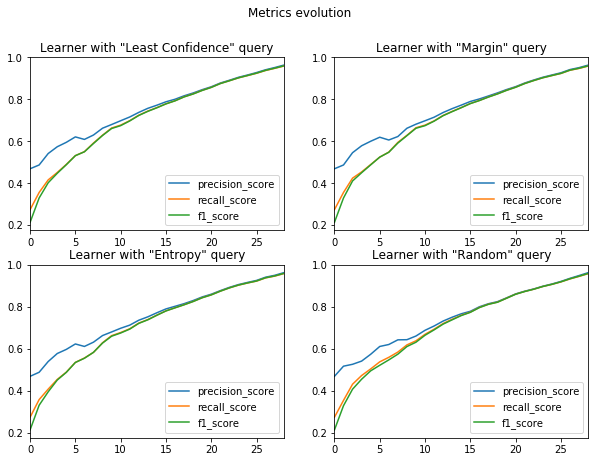

In [66]:
fig = plt.figure(figsize=(10,7))
fig.suptitle('Metrics evolution')
ax = plt.subplot(221)
lc_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Least Confidence" query')
ax = plt.subplot(222)
margin_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Margin" query')
ax = plt.subplot(223)
entropy_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Entropy" query')
ax = plt.subplot(224)
rand_oracle.performance_scores_.plot(ax=ax)
ax.set_title('Learner with "Random" query');

Dans la figure suivante, on observe qu'à part la sélection aléatoire, les autres méthodes choisissent des exemples de la même manière. Cela peut être dû au fléau de la dimension. Dans un espace de haute dimension, tous les exemples sont tous "proches" de la frontière de décision.

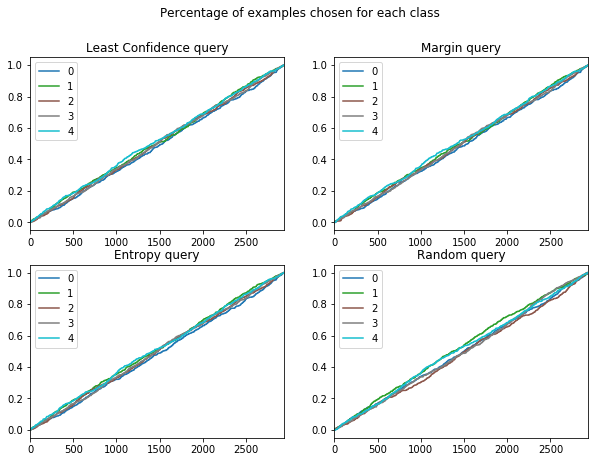

In [63]:
fig = plt.figure(figsize=(10,7))
fig.suptitle('Percentage of examples chosen for each class');

ax = plt.subplot(221)
ax = plot_choice_order(lc_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Least Confidence query')

ax = plt.subplot(222)
ax = plot_choice_order(margin_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Margin query')

ax = plt.subplot(223)
ax = plot_choice_order(entropy_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Entropy query')


ax = plt.subplot(224)
ax = plot_choice_order(rand_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Random query');

## Conclusion
Dans ce projet, nous avons implémenté et analysé un algorithme d'active learning. Nous avons vu comment un apprenant peut aider à sélectionner les exemples importants pour accélérer l'apprentissage. Les remarques suivantes sont tirées de nos expériences et de la recherche existante en Active Learning:
- L'active learning n'est pas la solution à toutes les situations où on manque de données. Parfois, il peut même avoir une pire performance que le choix aléatoire. Cela est dû au biais induit depuis le départ par la certitude que le modèle a par rapport à la qualité de la frontière qu'il a. Une classe minoritaire qui ne se trouve pas sur la frontière pourrait être ignorée pour longtemps et si l'algorithme s'arrête avant d'utiliser tous les exemples, il pourrait faire des erreurs graves.
- Les exemples choisis par un apprenant sont étroitement liés au modèle utilisé pour les prédictions. On ne peut pas s'attendre à un même résultat pour des modèles différents même si toutes les conditions sont les mêmes.

Dans l'exécution de l'algorithme sur des données textuelles, nous avons préalablement construit la matrice documents-termes. Il serait intéressant de faire une expérience plus réaliste où l'apprenant a accès seulement aux termes des documents déjà choisis. Cela permettrait d'observer si l'apprenant choisit des exemples qui lui permettent d'étendre son vocabulaire.